In [183]:
from baselines import *
from uncertainty import *

from autograd import numpy as np
from autograd import grad, elementwise_grad
from autograd.misc.optimizers import adam, sgd
from sklearn.datasets import make_moons
import numpy.random as npr
import pandas as pd
import numpy 
import scipy as sp
import matplotlib.pyplot as plt
import sys
import pickle
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

# Experiments with class overlap 

In this experiment, we generate toy training datasets consisted of two Gaussian blobs (class 0 and class 1) with some overalp. 
We test the performance of the four baselines for this model by the visualizing the decision boundaries, entropy, and accuracy vs. referral rate. 
We also test the model performance with test sets with different distributions from the training set.

In [2]:
# Generate a toy dataset for classification with controlled center and spread
def make_blobs(center1, center2, spread1, spread2, samples): 
    ''' input: center and spread of the Gaussian blobs. Samples is the number of class 0 / class 1'''
    class_0 = np.random.multivariate_normal(center1, spread1 * np.eye(2), samples)
    class_1 = np.random.multivariate_normal(center2, spread2 * np.eye(2), samples)
    x_train = np.vstack((class_0, class_1))
    y_train = np.array([0] * samples + [1] * samples)
    return x_train, y_train

In [3]:
center1 = [-0.2, -0.2]
center2 = [0.2, 0.2]
spread1 = 0.5
spread2 = 0.5
n_samples = 100
# if I make spread 1 not equal to spread 2, the gradient does not converge 

x_train, y_train = make_blobs(center1, center2, spread1, spread2, n_samples)

## Neural Network Training 
### Deterministic Model

In [4]:
# Deterministic model 
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

###neural network model design choices
width = 4
hidden_layers = 3
input_dim = x_train.shape[1]
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

In [5]:
###define design choices in gradient descent
params = {'step_size':1e-4, 
          'max_iteration':20000, 
          'random_restarts':1, 
          'check_point':500}
        
#fit my neural network to minimize MSE on the given data
nn.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = 0.0002)

Iteration 0 lower bound 565.536567737721; gradient mag: 856.2934627489138
Iteration 500 lower bound 407.8217372718497; gradient mag: 682.2770211980927
Iteration 1000 lower bound 273.2868252213745; gradient mag: 540.2430841356801
Iteration 1500 lower bound 185.25491750437587; gradient mag: 283.4914676499266
Iteration 2000 lower bound 161.74496007498396; gradient mag: 145.8471297047909
Iteration 2500 lower bound 150.65379974657466; gradient mag: 102.42377291600732
Iteration 3000 lower bound 142.30357026420742; gradient mag: 74.02694445246777
Iteration 3500 lower bound 136.28698291805966; gradient mag: 58.37846882015717
Iteration 4000 lower bound 132.86283950144804; gradient mag: 39.36018857402788
Iteration 4500 lower bound 130.05492137779797; gradient mag: 32.134495390466405
Iteration 5000 lower bound 127.24935811401451; gradient mag: 28.806250186231434
Iteration 5500 lower bound 125.23864718586006; gradient mag: 22.82273389585876
Iteration 6000 lower bound 123.84605324071661; gradient m

### Deep Ensemble

In [78]:
# Deep ensemble
reg_param = 0.0002
random = np.random.RandomState(rand_state)
N_bootstrap = 20

# load existing data
if os.path.exists('data/deep_ensemble0.pkl'):
    w_bootstrap = [] 
    nn_all = []
    for i in range(N_bootstrap):
        weights_here = pickle.load(open("data/deep_ensemble" + str(i) + ".pkl", "rb"))
        w_bootstrap.append(weights_here)

        #set random state to make the experiments replicable
        rand_state = 0
        random = np.random.RandomState(rand_state)
        nn_here = Feedforward(architecture, random=random)
        nn_here.weights = weights_here
        nn_all.append(nn_here)

# if no existing data, do a new run
else: 
    nn_all, w_bootstrap = ensemble(x_train, y_train, Feedforward, architecture, params, random, N_bootstrap, reg_param)
    
    # save data 
    masterdir = os.getcwd()
    for (i,nn) in enumerate(nn_all):
        with open('data/deep_ensemble' + str(i) + '.pkl', 'wb') as f:
            pickle.dump(nn.weights, f, pickle.HIGHEST_PROTOCOL)

### MC Dropout

In [52]:
# set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

width = 4
hidden_layers = 3
input_dim = x_train.shape[1]
output_dim = 1

architecture_dropout = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'dropout_rate': 0.1,
               'activation_fn_type': activation_fn_type,
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#instantiate a Feedforward neural network object
nn_dropout = Feedforward_Dropout(architecture_dropout, random=random)

params = {'step_size':1e-3, 
          'max_iteration':10000, 
          'random_restarts':1}

#fit my neural network to minimize MSE on the given data
nn_dropout.fit(x_train.T, y_train.reshape((1,-1)), params, reg_param = .001)

Iteration 0 lower bound 490.39329736681077; gradient mag: 651.230646175669
Iteration 1000 lower bound 138.29838391351996; gradient mag: 38.396953561476444
Iteration 2000 lower bound 128.22022993107925; gradient mag: 48.65653223832622
Iteration 3000 lower bound 130.11604508349632; gradient mag: 50.75997171504021
Iteration 4000 lower bound 135.36113500516134; gradient mag: 85.51118326438743
Iteration 5000 lower bound 121.34792906149048; gradient mag: 22.265088076718634
Iteration 6000 lower bound 119.61335913352552; gradient mag: 72.33457455919483
Iteration 7000 lower bound 123.80325741535037; gradient mag: 34.715935257487565
Iteration 8000 lower bound 118.37320126827346; gradient mag: 9.50412229467369
Iteration 9000 lower bound 119.68040918557523; gradient mag: 19.752317245799695


### BBVI

In [37]:
S = 20
max_iteration = 10000
step_size = 1e-3

Sigma_W = np.eye(nn.D)*5
sigma_y = 1

variational_params = variational_inference(Sigma_W, sigma_y, y_train, x_train.T, nn, nn.forward, S, max_iteration, step_size, 1)

Optimizing variational parameters...
Iteration 0 lower bound -700.902085567295; gradient mag: 9.065540605264943
Iteration 1000 lower bound -638.1306953767538; gradient mag: 11.768740569676654
Iteration 2000 lower bound -579.9653730555938; gradient mag: 18.009514054728573
Iteration 3000 lower bound -521.8220467106681; gradient mag: 27.854368482648074
Iteration 4000 lower bound -464.86544619467975; gradient mag: 20.970480447846626
Iteration 5000 lower bound -409.5699208003558; gradient mag: 12.526003738166677
Iteration 6000 lower bound -359.10520892098236; gradient mag: 99.14533762009592
Iteration 7000 lower bound -316.15052330496985; gradient mag: 59.89457073072903
Iteration 8000 lower bound -288.5461667403306; gradient mag: 137.3879992682866
Iteration 9000 lower bound -264.92195774515983; gradient mag: 58.903078625419056


In [ ]:
var_means = variational_params[0:nn.D]
var_variance = np.exp(variational_params[nn.D:])**2

x_test, y_test = make_blobs(center1, center2, spread1, spread2, n_samples)
posterior_sample_size = 100
posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
y_predict_noiseless = nn.forward(posterior_samples, x_test.T)
y_predict_noiseless = np.squeeze(y_predict_noiseless)

nn_list = []
for i in range(posterior_sample_size):
    #set random state to make the experiments replicable
    rand_state = 0
    random = np.random.RandomState(rand_state)
    tempNN = Feedforward(architecture, random=random)
    tempNN.weights = np.random.multivariate_normal(var_means, np.diag(var_variance)).reshape((1,var_means.shape[0]))
    nn_list.append(tempNN)

## Decision Boundary 

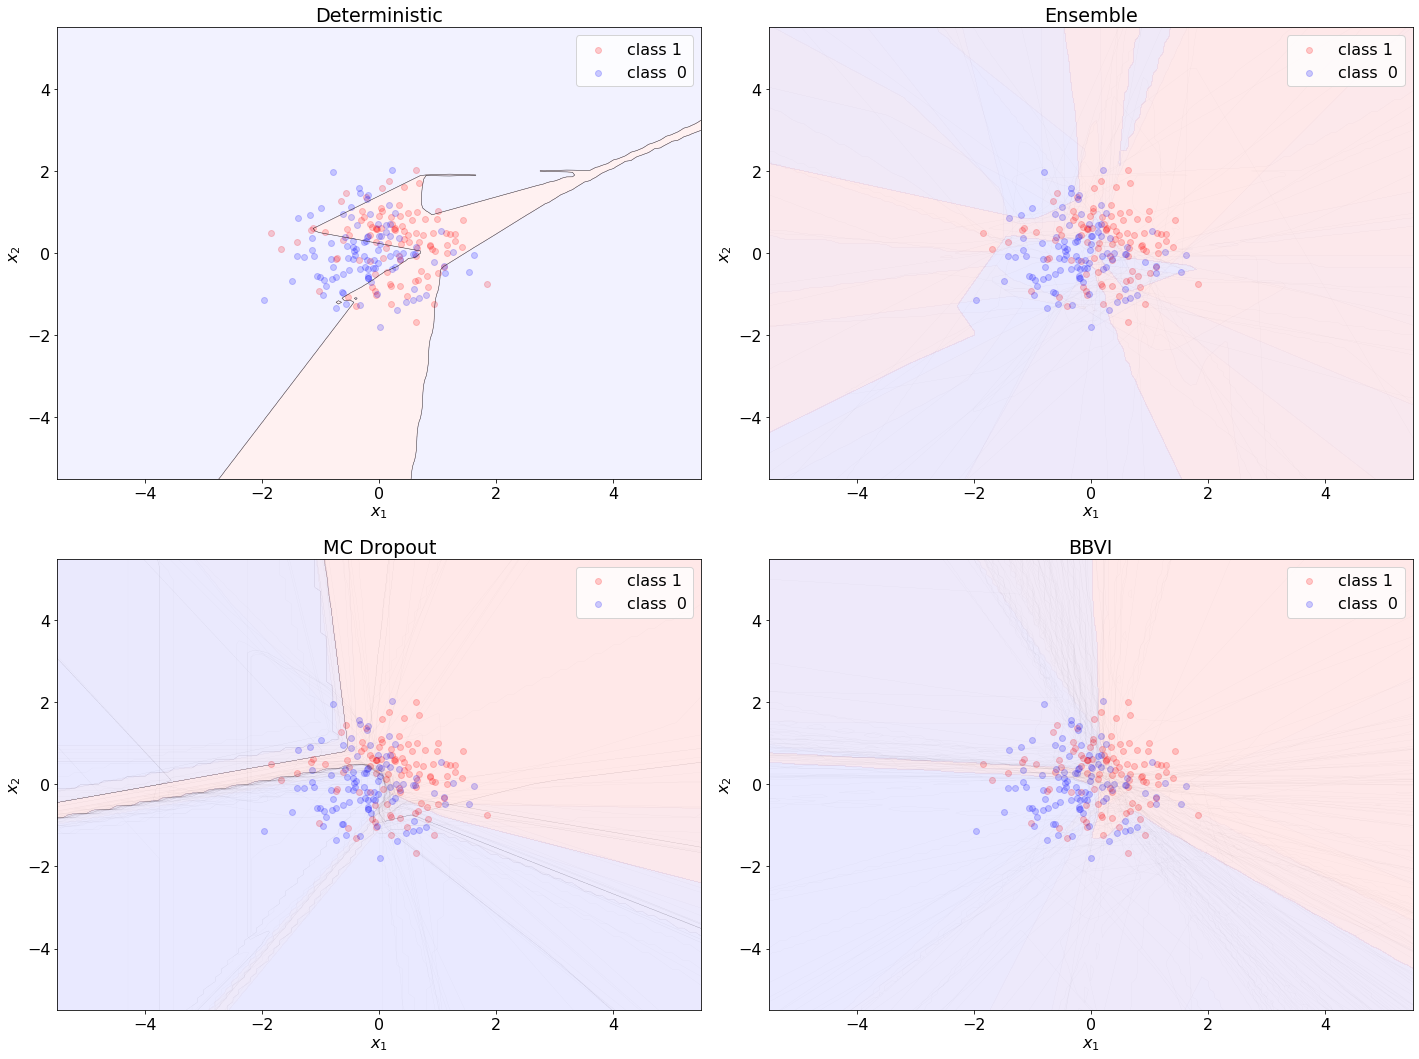

In [91]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
k = 0 
models = ['Deterministic', 'Ensemble', 'MC Dropout', 'BBVI']
for i in range(2):
    for j in range(2):
        
        ax[i][j].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
        ax[i][j].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class  0')
        if k == 0: 
            nn_here = [nn]
        elif k == 1: 
            nn_here = nn_all 
        elif k == 2: 
            nn_here = [nn_dropout]*100
        elif k == 3: 
            nn_here = nn_list
        plot_decision_boundary(x_train, y_train, nn_here, ax[i][j], poly_degree=1, shaded=True)
        ax[i][j].set_xlabel('$x_1$')
        ax[i][j].set_ylabel('$x_2$')
        ax[i][j].set_title(models[k])
        ax[i][j].legend(loc='best')
        k+= 1 
plt.tight_layout()
plt.show()

## Entropy for Deep Ensemble, MC Dropout, and BBVI

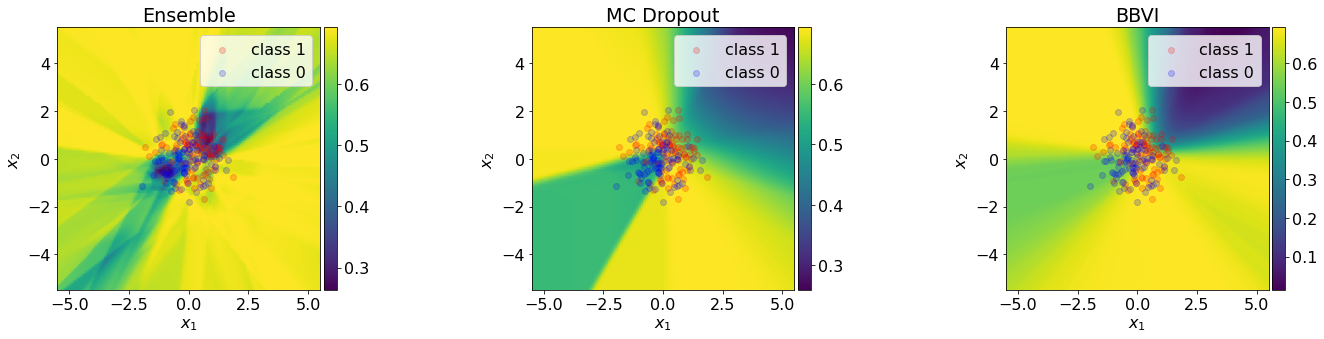

In [234]:
 
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
models = ['Ensemble', 'MC Dropout', 'BBVI']
for k in range(3):
    plt.rcParams.update({'font.size': 16})
    ax[k].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[k].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
    if k == 0: 
        nn_here = nn_all 
        cl=plot_entropycontours(x_train, y_train, nn_here, w_bootstrap, ax[k], models[k], poly_degree=1, shaded=True)
    
    elif k == 1:
        nn_here = nn_dropout
        weights_here = [nn_dropout.weights]*50
        cl=plot_entropycontours(x_train, y_train, nn_here, weights_here, ax[k], models[k], poly_degree=1, shaded=True)

    elif k == 2: 
        nn_here = nn_list
        cl=plot_entropycontours(x_train, y_train, nn, [posterior_samples[i].reshape((1, -1)) for i in range(posterior_samples.shape[0])], ax[k], models[k], poly_degree=1, shaded=True)
    
    divider = make_axes_locatable(ax[k])
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(cl, cax=cax, orientation='vertical')
    ax[k].set_xlabel('$x_1$')
    ax[k].set_ylabel('$x_2$')
    ax[k].set_title(models[k])
    ax[k].legend(loc='best')
    
plt.tight_layout()
plt.show()

## Accuracy vs. Referral Rate

In [189]:
# define functions to calculate accuracy and referral rate

def accuracy(retain_perc, samples, n_run, N, x_test, y_test):
    auc_dropout = np.zeros([len(retain_perc),N])
    auc_det = np.zeros([len(retain_perc),N])
    auc_ens = np.zeros([len(retain_perc),N])
    auc_bbvi = np.zeros([len(retain_perc),N])
    for (i, perc) in enumerate(retain_perc):
        for j in range(N):
            auc_dropout[i,j] = auc_calc(x_test, y_test, nn_dropout, N, perc, "mc")
            posterior_samples = np.random.multivariate_normal(var_means, np.diag(var_variance), size=posterior_sample_size)
            auc_bbvi[i,j] = auc_calc(x_test, y_test, nn, N, perc, "bbvi", weightlist=posterior_samples)

        auc_ens[i,:] = auc_calc(x_test, y_test, nn_all, 1, perc, "ensemble")

        # use sigmoid probability for retaining data
        auc_det[i,:] = auc_calc(x_test, y_test, nn, N, perc, "deterministic")

    return auc_det, auc_ens, auc_dropout, auc_bbvi


def accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc):

    auc_dropout_ub = np.percentile(auc_dropout, 97.5, axis=1)
    auc_dropout_lb = np.percentile(auc_dropout, 2.5, axis=1)

    auc_ub_ens = np.percentile(auc_ens, 97.5, axis=1)
    auc_lb_ens = np.percentile(auc_ens, 2.5, axis=1)

    auc_ub_bbvi = np.percentile(auc_bbvi, 97.5, axis=1)
    auc_lb_bbvi = np.percentile(auc_bbvi, 2.5, axis=1)
    
    plt.rcParams.update({'font.size': 16})
    fig,ax=plt.subplots(1,2,figsize=(20,5))
    ax[0].scatter(x_train[y_train == 1, 0], x_train[y_train == 1, 1], alpha=0.2, c='red', label='class 1')
    ax[0].scatter(x_train[y_train == 0, 0], x_train[y_train == 0, 1], alpha=0.2, c='blue', label='class 0')
    ax[0].scatter(x_test[y_test == 1, 0], x_test[y_test == 1, 1], alpha=0.8, c='blue', label='test class 1')
    ax[0].scatter(x_test[y_test == 0, 0], x_test[y_test == 0, 1], alpha=0.8, c='red', label='test class 0')
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
    ax[0].legend()
    ax[0].set_title('Visualization of training and test sets')
    ax[1].fill_between(retain_perc, auc_dropout_ub, auc_dropout_lb, color='blue', alpha=0.2)
    ax[1].plot(retain_perc, np.mean(auc_dropout,axis=1), 'blue', label='MC dropout')
    ax[1].plot(retain_perc, np.mean(auc_ens,axis=1), 'red', label='Ensemble')
    ax[1].plot(retain_perc, np.mean(auc_bbvi,axis=1), 'purple', label='BBVI')
    ax[1].plot(retain_perc, np.mean(auc_det,axis=1), 'green', label='Deterministic')
    ax[1].fill_between(retain_perc, auc_ub_bbvi, auc_lb_bbvi, color='purple', alpha=0.2)
    ax[1].fill_between(retain_perc, auc_ub_ens, auc_lb_ens, color='red', alpha=0.2)
    ax[1].set_xlabel("Retained Data")
    ax[1].set_ylabel("Accuracy")
    ax[1].set_title("Accuracy of different models")
    ax[1].set_xlim((min(retain_perc), max(retain_perc)))
#     ax[1].set_ylim((30, 90))
    ax[1].legend()
    plt.show()


In [226]:
# Accuracy vs referral rate 
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

x_test, y_test = make_blobs(center1, center2, spread1, spread2, n_samples)

retain_perc = np.linspace(0.2, 1, 10)

auc_det, auc_ens, auc_dropout, auc_bbvi = accuracy(retain_perc, samples, n_run, N, x_test, y_test)

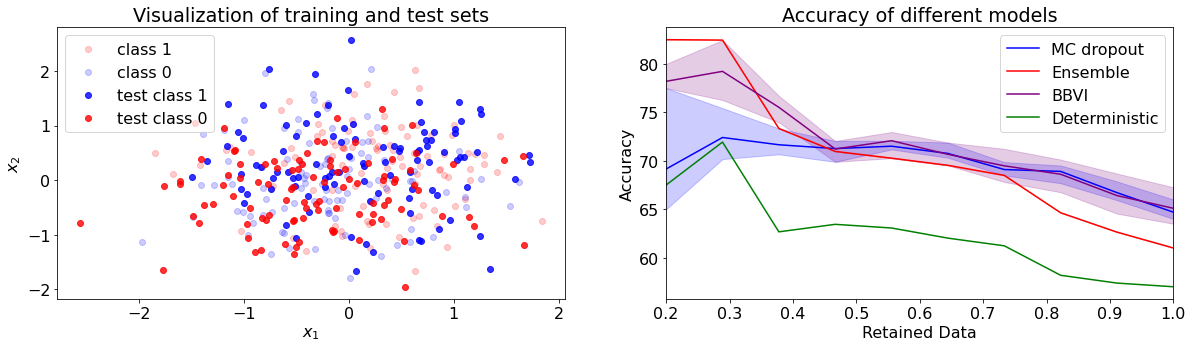

In [227]:
accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc)

In [228]:
# distribution shift # 1
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

# less overlap
c = 1
c1 = [c, c]
c2 = [-c, -c]
s1 = 0.5 
s2 = 0.5


x_test1, y_test1 = make_blobs(c1, c2, s1, s2, n_samples)
x_test2, y_test2 = make_blobs(center1, center2, spread1, spread2, n_samples)
x_test = np.vstack((x_test1, x_test2))
y_test = np.concatenate((y_test1, y_test2))

# Accuracy vs referral rate 
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

retain_perc = np.linspace(0.2, 1, 10)
auc_det, auc_ens, auc_dropout, auc_bbvi = accuracy(retain_perc, samples, n_run, N, x_test1, y_test1)

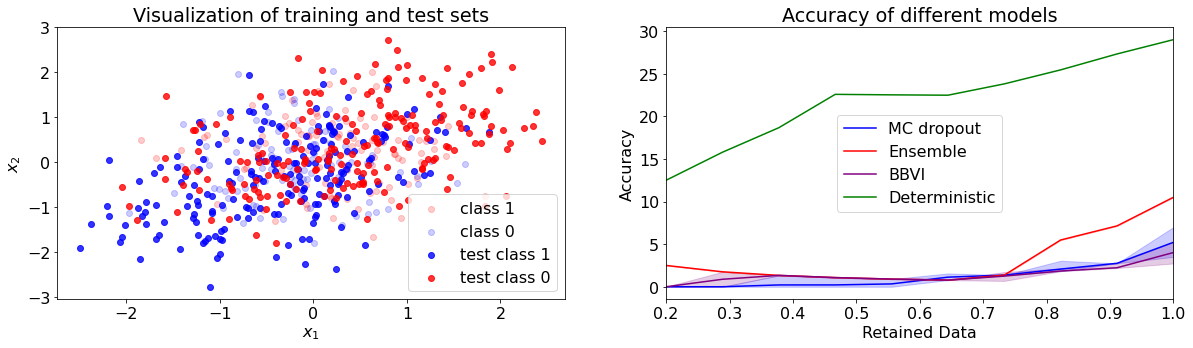

In [229]:
accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc)

In [230]:
# distribution shift #2
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

# less overlap
c = 2
c1 = [c, -c]
c2 = [-c, c]
s1 = 0.5 
s2 = 0.5

x_test1, y_test1 = make_blobs(c1, c2, s1, s2, n_samples)

x_test2, y_test2 = make_blobs(center1, center2, spread1, spread2, n_samples)
x_test = np.vstack((x_test1, x_test2))
y_test = np.concatenate((y_test1, y_test2))

# Accuracy vs referral rate 
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100


retain_perc = np.linspace(0.2, 1, 10)
auc_det, auc_ens, auc_dropout, auc_bbvi = accuracy(retain_perc, samples, n_run, N, x_test, y_test)

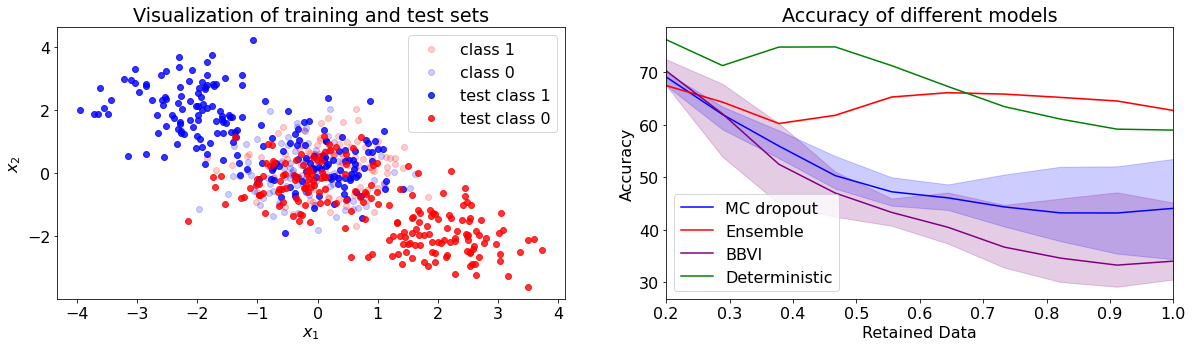

In [231]:
accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc)

In [232]:
# distribution shift #3
samples = 1000 
n_run = 100 # the number of times to call the NN for predicative entropy 
N = 100

# less overlap
c = 0.
c1 = [c, -c]
c2 = [-c, c]
s1 = 0.5 
s2 = 0.5

x_test1, y_test1 = make_blobs(c1, c2, s1, s2, n_samples)

x_test2, y_test2 = make_blobs(center1, center2, spread1, spread2, n_samples)
x_test = np.vstack((x_test1, x_test2))
y_test = np.concatenate((y_test1, y_test2))

retain_perc = np.linspace(0.2, 1, 10)
auc_det, auc_ens, auc_dropout, auc_bbvi = accuracy(retain_perc, samples, n_run, N, x_test, y_test)

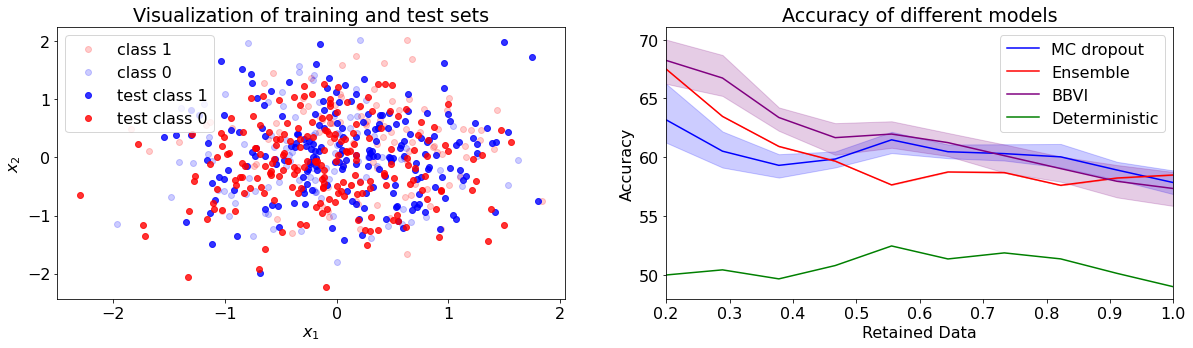

In [233]:
accuracy_plot(auc_det, auc_ens, auc_dropout, auc_bbvi, x_train, y_train, x_test, y_test, retain_perc)